In [1]:
import json
import re
import sys
import pandas as pd
import numpy as np

## Preprocessing

Load tweet data and perform preprocessing via `dataloader`

In [2]:
import dataloader

In [3]:
train_df = dataloader.load_data(data_file = '../data/train.data.jsonl', label_file = '../data/train.label.json', perform_stemming = False)
dev_df = dataloader.load_data(data_file = '../data/dev.data.jsonl', label_file = '../data/dev.label.json', perform_stemming = False)
test_df = dataloader.load_data(data_file = '../data/test.data.jsonl', label_file = None, perform_stemming = False)

In [4]:
train_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label
0,552800070199148544,how to respond to the murderous attack on char...,228,77,True,False,0,True,27923,185,...,0.908971,500,False,False,True,46,how to respond to the murderous attack on char...,[jews label anyone they do not like as anti se...,[imcharliehebdo],0
1,544388259359387648,you can not condemn an entire race nation or ...,352,252,False,False,0,False,745,2,...,0.413158,428,False,False,True,115,you can not condemn an entire race nation or ...,[how many times are we going to have the do n...,"[sydneysiege, sydneysiege, leftistluzer, sydne...",0
2,552805970536333314,attempts to extend blame for this to all musli...,876,400,False,False,0,False,74137,1431,...,0.954630,6423,False,True,True,149,attempts to extend blame for this to all musli...,[when will we see mass protests from amoderat...,"[charliehebdo, nonmuslimlivesmatter]",0
3,525071376084791297,rest in peace cpl nathan cirillo killed tod...,112,96,False,True,1,True,28103,418,...,0.933548,2140,True,True,True,157,rest in peace cpl nathan cirillo killed tod...,"[hot guy, hey frizz i was right downtown crazy...","[ottawashooting, ottawashooting, ottawashootin...",1
4,498355319979143168,people debating whether mikebrown shoplifted o...,802,298,False,False,0,False,55920,65,...,0.678947,25389,False,False,True,156,people debating whether mikebrown shoplifted o...,[yeah and shooting him times while not even...,"[mikebrown, ferguson, mikebrown, mikebrown, mi...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4636,524959027516932096,in response to ottawa incidents norad increas...,719,251,False,True,1,False,35630,158712,...,0.999994,13,True,False,True,136,in response to ottawa incidents norad increas...,"[falseflag here we go, norad could not even st...","[falseflag, operationchaos, falseflag, ottawa]",1
4637,524940940721418240,we are here we have people for you to talk to...,426,77,False,False,0,False,4132,55,...,0.499876,1075,False,False,True,158,we are here we have people for you to talk to...,[rt we are here we have people for you to tal...,"[ottawa, ottawa, ottawa, ottawa]",0
4638,580331453889708032,alert photo germanwings crash plane lost sig...,53,10,False,True,1,False,14406,965,...,0.993340,350,False,False,True,35,alert photo germanwings crash plane lost sig...,[],[],1
4639,552820384039706624,in solidarity with freedom of speech and relig...,197,66,False,False,0,True,18506,67,...,0.804808,5205,False,False,True,159,in solidarity with freedom of speech and relig...,"[yeah that will show em, do you mean to tell ...","[charliehebdo, nonegotiationswithterrorists]",0


## Text-only BERT with Tensorflow (using model *talkheads_ggelu_bert_en_base*)

In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [6]:
batch_size = 4
seed = 42
class_names = ["non-rumour", "rumour"]

In [7]:
bert_model_name = 'talkheads_ggelu_bert_en_base' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'talkheads_ggelu_bert_en_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talkheads_ggelu_bert_en_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talkheads_ggelu_bert_en_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talkheads_ggelu_bert_en_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

## Experiments

In [9]:
text_test = [train_df['text'][0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[  101  2129  2000  6869  2000  1996 25303  2886  2006  4918  2002  2497
   3527  2296  3780  1999  1996  2489  2088  2323  6140  2023  5181  3830
   3087  2027  2079  2025  2066  2004  3424  4100  2618  1998  3049  2127
   2008  2711  2194  2003  2736  2053  2028  2515 10047  7507 12190  2666
   5369  2497  3527  4487  9284  2054  7036  7486 11276  2000  2424 23979
   2003  2019  2012 21735  5462  1999  2037  2171  2025  1037  2061 27027
   9476  2748  2127  2009  4150  6737  2339 15301  2111  2040  2031  2498
   2000  2079  2007  2023  2111  2024 15958 15807  2011  2107  9254  1998
   4445  2572  1045  1045  2228  2023  2038  2210  2000  2079  2007  5025
   7486  6289  2017  2079  2025  2066  5181  9061  9061  2036  2027  4845
   2017  2247  2007 28378  4933  2059  1059   102]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.02647555 -0.00278487 -0.2055029  -0.18867041 -0.21202117 -0.26639563
  0.22680038 -0.47935328 -0.3327436   0.4024961  -0.2284549  -0.20179088]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19155797  1.4270308   0.5101866  ... -0.20545475 -0.4367153
  -0.27400377]
 [-0.86397916  0.23684627 -0.7454294  ...  0.10063817  0.87818325
  -0.7364311 ]
 [-0.38800386  0.6043348  -0.5000459  ... -0.7781125   0.13778304
  -1.1118891 ]
 ...
 [ 1.6590769  -1.4746101  -0.6776424  ...  1.0360385   1.4547545
  -0.1817909 ]
 [ 1.0735137   0.73393095 -0.24342741 ... -1.0539343   1.4175123
   0.17375734]
 [ 0.5341886  -0.24081212 -0.9187761  ...  0.24986982  0.5860103
   0.9040197 ]]


## Training

In [12]:
# Define f1 metric
# Code from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
def f1(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value) / (precision_value+recall_value+K.epsilon()))

Using TensorFlow backend.


In [14]:
def build_classifier_model():
    
    preprocessor = hub.load(tfhub_handle_preprocess)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    tokenize = hub.KerasLayer(preprocessor.tokenize, name = 'tokenizer')
    
    tokenized_input = [tokenize(text_input)]
    
    # pack input sequences for the Transformer encoder
    seq_length = 512  
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length), name = 'bert_pack_inputs')  # Optional argument.
    
    encoder_inputs = bert_pack_inputs(tokenized_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [47]:
"""
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)
"""

"\ndef build_classifier_model():\n    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')\n    encoder_inputs = preprocessing_layer(text_input)\n    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')\n    outputs = encoder(encoder_inputs)\n    net = outputs['pooled_output']\n    net = tf.keras.layers.Dropout(0.1)(net)\n    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)\n    return tf.keras.Model(text_input, net)\n"

In [15]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.37377807]], shape=(1, 1), dtype=float32)


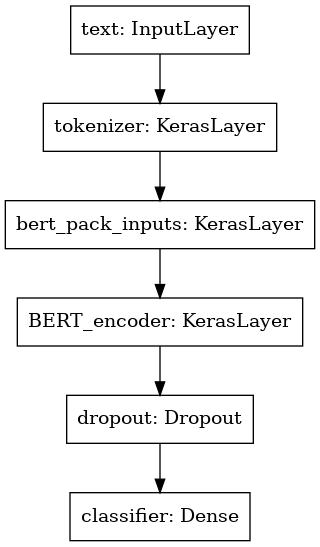

In [16]:
tf.keras.utils.plot_model(classifier_model)

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.text, train_df.label.values))
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((dev_df.text, dev_df.label.values))
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_df.text))
test_ds = test_ds.batch(batch_size)

# BERT model from TF-Hub for local development

This BERT model was used for development purposes and makes use of the validation set to evaluate the performance on the given task.

In [17]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), recall, precision, f1]

In [18]:
epochs = 7
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()


num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [19]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [20]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/7
1161/1161 [==============================] - 2086s 2s/step - loss: 0.6179 - binary_accuracy: 0.6962 - recall: 0.2705 - precision: 0.2952 - f1: 0.2666 - val_loss: 0.6559 - val_binary_accuracy: 0.8224 - val_recall: 0.6575 - val_precision: 0.6023 - val_f1: 0.6013
Epoch 2/7
1161/1161 [==============================] - 2061s 2s/step - loss: 0.5068 - binary_accuracy: 0.8610 - recall: 0.6651 - precision: 0.6626 - f1: 0.6423 - val_loss: 0.5472 - val_binary_accuracy: 0.8845 - val_recall: 0.7126 - val_precision: 0.6862 - val_f1: 0.6813
Epoch 3/7
1161/1161 [==============================] - 2060s 2s/step - loss: 0.2709 - binary_accuracy: 0.9383 - recall: 0.7619 - precision: 0.7621 - f1: 0.7498 - val_loss: 0.7230 - val_binary_accuracy: 0.8793 - val_recall: 0.6149 - val_precision: 0.6443 - val_f1: 0.6146
Epoch 4/7
1161/1161 [==============================] - 2059s 2s/step - loss: 0.1005 - binary_accuracy: 0.97

### Plot accuracy and loss over time

In [22]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

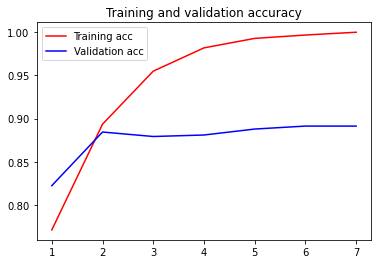

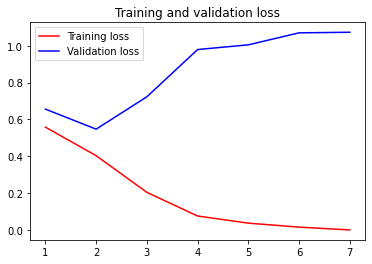

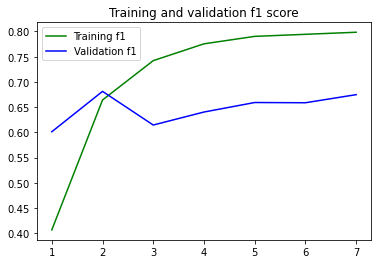

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color = "red", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color="red", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, f1, 'b', color = "green", label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [24]:
classifier_model.save("./pure_bert/pure_bert_v14", include_optimizer=False)

## Inference

In [25]:
result = tf.sigmoid(classifier_model.predict(test_ds))

In [26]:
result = np.round(result).astype(int)

In [27]:
predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

,id,target
0,544382249178001408,rumour
1,525027317551079424,rumour
2,544273220128739329,rumour
3,499571799764770816,non-rumour
4,552844104418091008,non-rumour
...,...,...
576,553581227165642752,rumour
577,552816302780579840,non-rumour
578,580350000074457088,rumour
579,498584409055174656,non-rumour


In [28]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v14.json', 'w') as f:
    json.dump(submission, f)

# BERT model from TF-Hub for CodaLab competition

For the CodaLab compeition, the train and development dataset has been merged to increase the size of the training set.

In [18]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label
0,552800070199148544,how to respond to the murderous attack on char...,228,77,True,False,0,True,27923,185,...,0.908971,500,False,False,True,46,how to respond to the murderous attack on char...,[jews label anyone they do not like as anti se...,[imcharliehebdo],0
1,544388259359387648,you can not condemn an entire race nation or ...,352,252,False,False,0,False,745,2,...,0.413158,428,False,False,True,115,you can not condemn an entire race nation or ...,[how many times are we going to have the do n...,"[sydneysiege, sydneysiege, leftistluzer, sydne...",0
2,552805970536333314,attempts to extend blame for this to all musli...,876,400,False,False,0,False,74137,1431,...,0.954630,6423,False,True,True,149,attempts to extend blame for this to all musli...,[when will we see mass protests from amoderat...,"[charliehebdo, nonmuslimlivesmatter]",0
3,525071376084791297,rest in peace cpl nathan cirillo killed tod...,112,96,False,True,1,True,28103,418,...,0.933548,2140,True,True,True,157,rest in peace cpl nathan cirillo killed tod...,"[hot guy, hey frizz i was right downtown crazy...","[ottawashooting, ottawashooting, ottawashootin...",1
4,498355319979143168,people debating whether mikebrown shoplifted o...,802,298,False,False,0,False,55920,65,...,0.678947,25389,False,False,True,156,people debating whether mikebrown shoplifted o...,[yeah and shooting him times while not even...,"[mikebrown, ferguson, mikebrown, mikebrown, mi...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,the soldier shot dead in wednesday is ottawa a...,119,36,False,False,0,True,88483,306,...,0.727071,1903,True,True,True,101,the soldier shot dead in wednesday is ottawa a...,"[my condolences go out to your family, that ...","[hamont, ottawashooting, notinvain]",1
5217,552784600502915072,charlie hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,0.948267,0,True,True,True,158,charlie hebdo became well known for publishing...,[i am muslim would you call me violent even ...,[islamphobiaatitsbest],0
5218,499696525808001024,we got through that is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,0.982027,1163,False,True,True,159,we got through that is a sniper on top of a t...,[we got through that is a sniper on top of a ...,"[ferguson, ferguson, ferguson, responsiblejour...",0
5219,580320612155060224,last position of germanwings flight u at ...,3092,480,False,True,1,True,7991,2384,...,0.998276,1131,True,True,True,146,last position of germanwings flight u at ...,[where was the pilot how come he did not use ...,"[4u9525, 4u9525, 4u9525, 4u9525, 4u9525, 4u952...",1


In [19]:
combined_ds = tf.data.Dataset.from_tensor_slices((combined_df.text, combined_df.label.values))
combined_ds = combined_ds.batch(batch_size)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy()]

Training for 7 epochs

In [21]:
epochs = 7
steps_per_epoch = tf.data.experimental.cardinality(combined_ds).numpy()



num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [22]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [23]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=combined_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/7
1306/1306 [==============================] - 2242s 2s/step - loss: 0.6095 - binary_accuracy: 0.7034
Epoch 2/7
1306/1306 [==============================] - 2218s 2s/step - loss: 0.4826 - binary_accuracy: 0.8728
Epoch 3/7
1306/1306 [==============================] - 2219s 2s/step - loss: 0.2940 - binary_accuracy: 0.9256
Epoch 4/7
1306/1306 [==============================] - 2218s 2s/step - loss: 0.1209 - binary_accuracy: 0.9724
Epoch 5/7
1306/1306 [==============================] - 2218s 2s/step - loss: 0.0506 - binary_accuracy: 0.9913
Epoch 6/7
1306/1306 [==============================] - 2219s 2s/step - loss: 0.0278 - binary_accuracy: 0.9947
Epoch 7/7
1306/1306 [==============================] - 2221s 2s/step - loss: 0.0107 - binary_accuracy: 0.9982


In [24]:
classifier_model.save("./pure_bert/pure_bert_v16", include_optimizer=False)

## Inference

In [25]:
result = tf.sigmoid(classifier_model.predict(test_ds))

In [26]:
result = np.round(result).astype(int)

In [27]:
predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

,id,target
0,544382249178001408,rumour
1,525027317551079424,rumour
2,544273220128739329,rumour
3,499571799764770816,non-rumour
4,552844104418091008,non-rumour
...,...,...
576,553581227165642752,rumour
577,552816302780579840,non-rumour
578,580350000074457088,rumour
579,498584409055174656,non-rumour


In [28]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output_v16.json', 'w') as f:
    json.dump(submission, f)